# Aircrew trainee scheduling with seniority constraints and preferences
[![tip8_aircrew_trainees_seniority.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/glebbelov/modeling-tips/tip8_aircrew_trainees_seniority.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/glebbelov/modeling-tips/tip8_aircrew_trainees_seniority.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/glebbelov/modeling-tips/tip8_aircrew_trainees_seniority.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/glebbelov/modeling-tips/tip8_aircrew_trainees_seniority.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/glebbelov/modeling-tips/tip8_aircrew_trainees_seniority.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/glebbelov/modeling-tips/tip8_aircrew_trainees_seniority.ipynb)](https://colab.ampl.com)

Description: Aircrew trainee scheduling with seniority constraints and preferences

Tags: trainee scheduling, aircrew scheduling, employee scheduling, seniority constraints, seniority ranking, amplpy

Notebook author: Gleb Belov <<gleb@ampl.com>>

References:
1. G. Kozanidis (2017). Optimal assignment of aircrew trainees to simulator and classroom training sessions subject to seniority and preference restrictions. Journal of Air Transport Management 59, 143-154.

In [1]:
# Install dependencies
%pip install -q amplpy pandas

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["gurobi", "xpress"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

## Mathematical model

This notebook considers a realistic trainee scheduling model from [1] involving classroom capacities, language and (reverse) seniority constraints, and seniority-ranked preferences. The (compulsory) seniority constraints are modeled by a Preferential Bidding System (PBS)-style secondary objective function.

**Sets:**
- $I$ - set of crew trainees,
- $T$ - set of training sessions,
- $V_i$ - set of valid sessions of trainee $i\in I$,
- $Pos$ - set of crew positions:  captain (CP), first officer (FO), purser (PU), or flight attendant (FA),
- $Grp$ - set of trainee groups: all, cockpit (CK), cabin (CB).

**Parameters:**
- $P_i\in Pos$ - position of trainee $i\in I$,
- $S_i$ - seniority. The smaller this number, the more senior the corresponding crew member,
- $E_i$ - flight capability expiration. 0: end of the current month, 1: end of the next month, 2: end of the next to the following month,
- $L_i$ - spoken language. 0: the trainee speaks both of the alternative languages, 1: only the first language, 2: only the second language,
- $Pr_{it}$ - priority of trainee $i$ for valid session $t$. Priorities are non-negative integers. Higher priorities mean higher preference. Zero priority means that the trainee does not want to be assigned to this session. All positive priorities for the same trainee should be different, while zero priority can be expressed for multiple sessions,
- $MAX_p$ - capacity of each training session for trainees of position $p\in Pos$,
- $MAX^+_g$ - capacity of each training session for trainees of group $g\in Grp$.

The aim is to find an optimal assignment of trainees to training sessions which minimizes the number of training slots that remain empty, while also satisfying a list of hard and soft requirements. The satisfaction of the hard restrictions is unnegotiable, whereas the soft ones must be satisfied to the greatest possible extent. The **hard restrictions** that must be satisfied are the following:
- Capacity constraints for each training session,
- One of the two alternative languages must be selected for each session,
- Every crew member with expiration 0 must be assigned to one of his/her valid sessions,
- Reverse expiration and reverse seniority restrictions. Suppose that there exists a slot in a training session, which is only valid to a specific subset of crew members, none of which has expressed positive preference for being assigned to this session. Since the minimization of the total number of empty slots is the model's primary objective, one of these crew members must eventually be assigned to this session. The reverse expiration restrictions, considered first, dictate that this should be the crew member with the lowest expiration (his/her flight capability should expire sooner) among them. Assume now, that two or more trainees have the lowest expiration. The reverse seniority restrictions, considered next, dictate that this should be the least senior trainee among all the trainees with the lowest expiration.

Additionally, the following **soft restrictions** must be satisfied:
- The maximum possible preference satisfaction for each crew member must be attained, according to strict seniority. This means that no crew member's preference should be satisfied at the expense of the dissatisfaction of a more senior crew member's preference.
- The maximum possible preference satisfaction of each individual crew member must be attained, according to the list of priorities that he/she has expressed.

**Decision variables:**
- $x_{it}$ - binary decision variable, takes value $1$ *iff* trainee $i\in I$ is assigned to session $t\in V_t$,
- $y_i$ - binary decision variable that takes the value 1 *iff* trainee i remains unassigned, $i\in I$: $E_i = 1$ or $2$,
- $u_t$: binary decision variable that takes the value 1 if language 1 is selected for training session t, and 0 if language 2 is selected instead, $t\in T$,
- $w$: total number of crew trainees that remain unassigned.

The **optimization model**, formulated below in AMPL, follows [1] in most parts, while differs as follows:
- The reverse expiration and seniority constraints are sublimated via a Preferential Bidding System (PBS)-style secondary objective function. It remains to be shown that minimizing the objective function `ReverseSeniority` provides constraints (8), (9), (22-25), and (26--29) from [1], as well as resolves the 'pitfall' from page 146.
- The lexicographic approach for preference ranking by seniority is implemented via multiple objectives submitted to the solver in a single model.
No variables are fixed while optimizing the different objectives.

## Test instance generation

Define class `Instance` holding a problem instance.

In [3]:
class Instance:
    def __init__(self):
        ## Data arrays / matrices for all trainees
        self.nT = 0
        self.P = []
        self.S = []
        self.L = []
        self.E = []
        self.V = []
        self.Pr = []
        ## Capacity constraints
        self.cap_kind = []
        self.MAX = []
        self.cap_plus_kind = []
        self.cap_plus_which = []
        self.MAXPlus = []

Define class `InstGenParams` with instance generation papameters according to [1].

In [4]:
import math

class InstGenParams:
    def __init__(self, N):
        self.N = N
        self.T = math.ceil(N/5)
        ## Ranges and probabilities
        self.position_kind = ["CP", "FO", "PU", "FA"]
        self.position_prob = [0.25, 0.25, 0.25, 0.25]
        self.language_prob = [0.5, 0.25, 0.25]
        self.expiration_prob = [0.5, 0.25, 0.25]
        self.N_sess_rng = [1, math.floor(self.T/2)]
        self.pref_0 = 0.5
        ## These are constant for all instances
        self.cap_kind = ["CP", "FO", "PU", "FA"]
        self.MAX = [4, 4, 4, 4]
        self.cap_plus_kind = ["All", "CK", "CB"]
        self.cap_plus_which = [[1, 2], [1, 2], [1, 3], [1, 3]]
        self.MAXPlus = [10, 6, 6]

Function to generate an instance.

In [5]:
import numpy as np
import pandas as pd

def GenInstance(genpar, rng):
    inst = Instance()
    inst.nT = genpar.T
    inst.S = np.arange(genpar.N)              # Seniority 0..N-1
    rng.shuffle(inst.S)
    for itr in range(0, genpar.N):
        inst.P.append(rng.choice(np.arange(1, len(genpar.position_prob)+1),  # 1-based
                                 p=genpar.position_prob))
        inst.L.append(rng.choice(len(genpar.language_prob), p=genpar.language_prob))
        inst.E.append(rng.choice(len(genpar.expiration_prob), p=genpar.expiration_prob))
        N_feas_sess = rng.integers(genpar.N_sess_rng[0], genpar.N_sess_rng[1]+1)
        V = rng.choice(np.arange(1, genpar.T+1),                   # 1-based
                       size=N_feas_sess, replace=False)
        inst.V.append( V )
        N_pr_0 = rng.binomial(N_feas_sess, genpar.pref_0)
        PrByV = np.concatenate( (np.zeros(N_pr_0), np.arange(1, N_feas_sess-N_pr_0+1)) )
        assert N_feas_sess == len(PrByV)
        rng.shuffle(PrByV)
        Pr = np.zeros(genpar.T)
        for k, t in enumerate(V):
            Pr[t-1] = PrByV[k]
        inst.Pr.append( Pr )
    # Capacities
    inst.cap_kind = genpar.cap_kind
    inst.MAX = genpar.MAX
    inst.cap_plus_kind = genpar.cap_plus_kind
    inst.cap_plus_which = genpar.cap_plus_which
    inst.MAXPlus = genpar.MAXPlus
    return inst

Generate instance.

In [6]:
rng = np.random.default_rng(122807528840384100672342137672332424406)

genpar = InstGenParams(200)             # With the Demo license, set up to 50
inst = GenInstance(genpar, rng)

## AMPL model

The below model is saved to file `airtrainee.mod`.

In [7]:
%%writefile airtrainee.mod

set I;              # Trainees
set T;              # Training sessions
set V{I} in T;      # Valid sessions for each trainee
set Pos;            # Positons
set PosPlus;        # Meta-positions (e.g, All, Cockpit, Cabin)
set MAXPlusWhich{Pos} in PosPlus;

param P{I} in Pos;  # Trainee's position
param S{I};         # Seniority (smaller value <=> higher seniority)
param L{I};         # Language (0 - both, 1 or 2 - one only)
param E{I};         # Expiration: 0 - this month, 1 - next month, 2 - in 2 months
param Pr{I, T};     # Priority: 0 - not wanted, larger value <=> higher preference
param MAX{Pos};     # Position capacity
param MAXPlus{PosPlus};  # Aggregated capacities (All, CK, CB)

var x{i in I, t in T} binary <= if t in V[i] then 1 else 0;
var y{i in I} binary <= if E[i]>0 then 1 else 0;      # Trainee i unassigned
var u{T} binary;    # 1 <=> language 1, 0 <=> language 2
var w >=0;          # Number of unassigned trainees

s.t. Assign_E0 {i in I: E[i]==0}:
  sum {t in V[i]} x[i, t] == 1;

s.t. Unassigned_E12 {i in I: E[i]>0}:
  sum {t in V[i]} x[i, t] + y[i] == 1;

s.t. Sum_Unassigned: w == sum {i in I: E[i]>0} y[i];

s.t. Language_1 {t in T}:
  u[t]<0.5 ==> sum {i in I: L[i]==1 and t in V[i]} x[i, t] <= 0;

s.t. Language_2 {t in T}:
  u[t]>=0.5 ==> sum {i in I: L[i]==2 and t in V[i]} x[i, t] <= 0;

s.t. Capacity {p in Pos, t in T}:
  sum {i in I: p==P[i] and t in V[i]} x[i, t] <= MAX[p];

s.t. Capacity_Meta {p in PosPlus, t in T}:
  sum {i in I: p in MAXPlusWhich[P[i]] and t in V[i]} x[i, t] <= MAXPlus[p];

suffix objpriority;
param S_range := max {i in I} S[i] - min {i in I} S[i];

# The primary objective
minimize Total_Unassigned: w suffix objpriority S_range + 2;
# let Total_Unassigned.objpriority := card(I) + 2;

# Trainee preferences, ranked by seniority
set SenLevels := setof {i in I} S[i];
param prefMax {i in I} := max {t in V[i]} Pr[i, t];
minimize PrefsRanked {s in SenLevels}:
  sum {i in I, t in T: s==S[i] and t in V[i]} (prefMax[i] - Pr[i, t])
    suffix objpriority max {i in I} S[i] + 1 - s;

# Reverse seniority constraints,
# sublimated as a post-processing phase objective
maximize ReverseSeniority:
  sum {i in I, t in T: 0<E[i] and t in V[i] and 0==Pr[i, t]}
    S[i] * x[i, t]
    suffix objpriority 0;

Overwriting airtrainee.mod


Function to pass an instance to the AMPL model.

In [8]:
def MakeAMPLInstance(inst):
    ampl = AMPL()
    ampl.read("airtrainee.mod")
    # Fill data
    ampl.set["I"] = np.arange(1, len(inst.P)+1)
    ampl.set["T"] = np.arange(1, inst.nT+1)
    for i, vi in enumerate(inst.V):
        ampl.set["V"][i+1] = vi
    ampl.set["Pos"] = np.arange(1, len(genpar.position_prob)+1)
    ampl.set["PosPlus"] = np.arange(1, len(genpar.MAXPlus)+1)
    for i, vi in enumerate(inst.cap_plus_which):
        ampl.set["MAXPlusWhich"][i+1] = vi
    ampl.param["P"] = inst.P
    ampl.param["S"] = inst.S
    ampl.param["L"] = inst.L
    ampl.param["E"] = inst.E
    ampl.param["Pr"] = pd.DataFrame(data = inst.Pr,
                                    index = range(1, len(inst.P)+1),
                                    columns = range(1, inst.nT+1))
    ampl.param["MAX"] = inst.MAX
    ampl.param["MAXPlus"] = inst.MAXPlus
    
    return ampl

Solve the instance.

In [9]:
ampl = MakeAMPLInstance(inst)

ampl.solve(solver="gurobi", gurobi_options="outlev=0 iis=1 multiobj=1 tech:timing=1")


Gurobi 11.0.1:   tech:outlev = 0
  alg:iisfind = 1
  obj:multi = 1
  tech:timing = 1
Gurobi 11.0.1: optimal solution; objective 0
Individual objective values:
	_sobj[1] = 0
	_sobj[2] = 135
	_sobj[3] = 116
	_sobj[4] = 1
	_sobj[5] = 55
	_sobj[6] = 23
	_sobj[7] = 76
	_sobj[8] = 0
	_sobj[9] = 21
	_sobj[10] = 108
	_sobj[11] = 0
	_sobj[12] = 11
	_sobj[13] = 0
	_sobj[14] = 116
	_sobj[15] = 0
	_sobj[16] = 0
	_sobj[17] = 33
	_sobj[18] = 34
	_sobj[19] = 49
	_sobj[20] = 9
	_sobj[21] = 0
	_sobj[22] = 165
	_sobj[23] = 15
	_sobj[24] = 1
	_sobj[25] = 13
	_sobj[26] = 84
	_sobj[27] = 45
	_sobj[28] = 110
	_sobj[29] = 1
	_sobj[30] = 45
	_sobj[31] = 63
	_sobj[32] = 33
	_sobj[33] = 3
	_sobj[34] = 76
	_sobj[35] = 49
	_sobj[36] = 125
	_sobj[37] = 93
	_sobj[38] = 30
	_sobj[39] = 0
	_sobj[40] = 33
	_sobj[41] = 87
	_sobj[42] = 75
	_sobj[43] = 15
	_sobj[44] = 100
	_sobj[45] = 100
	_sobj[46] = 105
	_sobj[47] = 126
	_sobj[48] = 0
	_sobj[49] = 63
	_sobj[50] = 26
	_sobj[51] = 1
	_sobj[52] = 18
	_sobj[53] = 108
	_sob

Display some results

In [10]:
for obj in ampl.get_objectives():
    print("{:20} = {}".format(obj[0], obj[1].get_values().to_pandas().T))

PrefsRanked          =              0    1    2    3    4    5    6    7    8    9    ...  190  191  \
PrefsRanked    9    6   45   33    0   49    0   39   27   76  ...   30   95   

             192  193  194  195  196  197  198  199  
PrefsRanked  105   14    0   45  156    4   34   33  

[1 rows x 200 columns]
ReverseSeniority     =                      0
ReverseSeniority  8396
Total_Unassigned     =                   0
Total_Unassigned  0


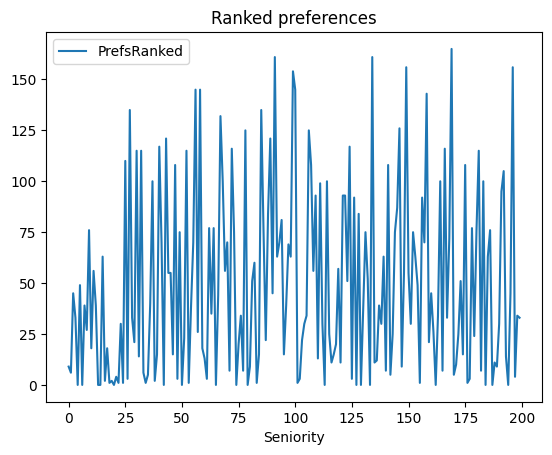

In [11]:
import matplotlib.pyplot as plt 
  
prefs = ampl.get_objective("PrefsRanked").get_values().to_pandas()
plot = prefs.plot(title="Ranked preferences", xlabel="Seniority")

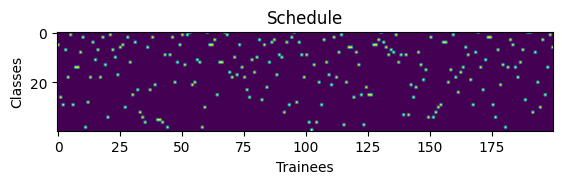

In [12]:
x = ampl.get_variable("x").get_values().to_pandas().unstack().T
plt.imshow( x ) 
  
plt.title( "Schedule" ) 
plt.xlabel( "Trainees" )
plt.ylabel( "Classes" )
plt.show() 

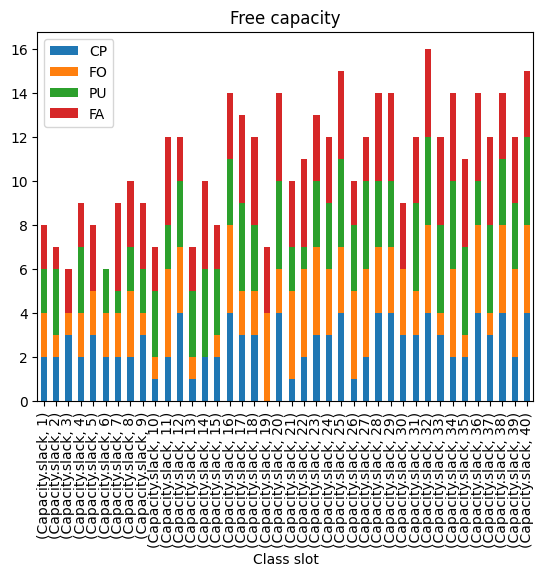

In [13]:
cap = ampl.get_data("Capacity.slack").to_pandas().unstack().T
cap.columns = inst.cap_kind
plot = cap.plot(title="Free capacity", xlabel="Class slot", kind="bar", stacked=True)
plt.show()

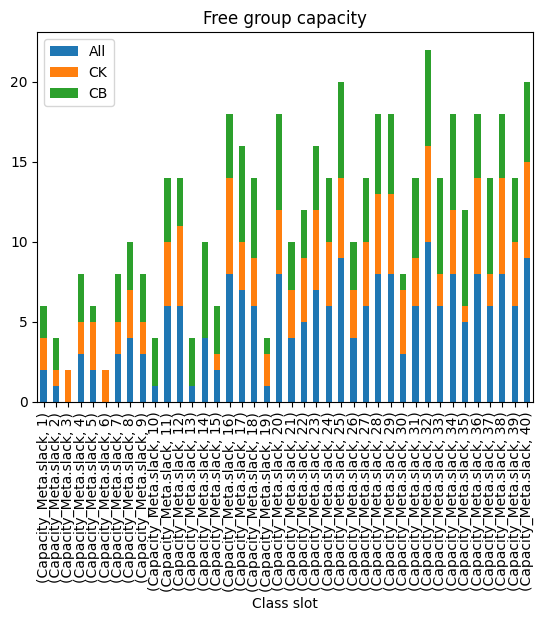

In [14]:
cap = ampl.get_data("Capacity_Meta.slack").to_pandas().unstack().T
cap.columns = inst.cap_plus_kind
plot = cap.plot(title="Free group capacity", xlabel="Class slot", kind="bar", stacked=True)
plt.show()

In [15]:
ampl.get_variable("u").get_values().to_pandas().T   # Session language

,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,36,37,38,39,40
u.val,1,0,1,0,0,0,0,1,0,0,...,1,1,0,0,1,0,1,0,0,1


In [16]:
min(ampl.get_data("Language_1").to_pandas().T)      ## Minimal value of the logical constraints (1 when all true)

1

In [17]:
min(ampl.get_data("Language_2").to_pandas().T)

1